# WTF is the Power of a Frequency Band?



I created this notebook because I wanted to understand how the LF and HF spectral components of HRV are computed.

They are defined as "the power within a frequency band", referring to the power spectral density (PSD) of the HRV-Signal.

Now, having only used the fourier transform for locating interesting frequencies, I was not sure what the PSD really is or how to calculate the power over a range of frequencies (which is what is meant by the term "frequency band").

What I did understand however was the following:
* The PSD can be calculated (or rather estimated) from the FFT of a signal.
* To be useful in diagnosis, values such as LF and HF would have to be independent of the sampling rate and length of a signal.
* The total power of a signal is equal to it's variance.

Therefore, we will now get rid of the past tense and create a signal with varying sampling rate and length. First, we create the base signal as a sine wave overlayed with a random walk.

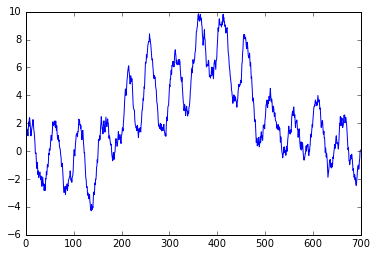

In [234]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

d_normal = 0.7 # step size = 1 / sampling rate
sin_freq = 0.02 # hz
signal = np.cumsum(np.random.random(1000) - 0.5) + np.sin(np.arange(1000) * 2 * np.pi * sin_freq * d_normal) * 2
xvals = np.arange(signal.shape[0]) * d_normal
plt.plot(xvals, signal)
plt.show()

So far, so good. Now we need to modify the signal. First, we create a signal with higher sampling rate by just repeating each sample twice.

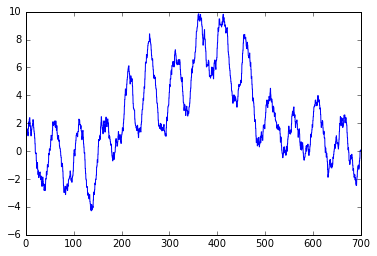

normal   [ 0.39392141  1.05745557  1.17449239  1.58799205  1.49665423]
highres  [ 0.39392141  0.39392141  1.05745557  1.05745557  1.17449239]


In [235]:
signal_highres = np.repeat(signal, 2)
xvals_highres = np.zeros(signal.shape[0] * 2)
xvals_highres[::2] = xvals
xvals_highres[1::2] = xvals + 0.5 * (xvals[1] - xvals[0])
plt.plot(xvals_highres, signal_highres)
plt.show()
print("normal  ", signal[:5])
print("highres ", signal_highres[:5])

Now we create the longer signal by just repeating our whole base signal twice.

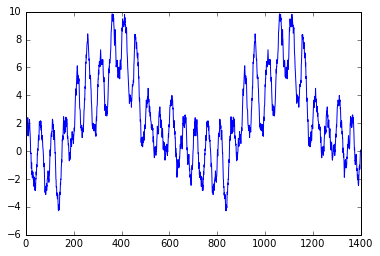

In [236]:
signal_double = np.concatenate((signal, signal))
xvals_double = np.arange(signal_double.shape[0]) * (xvals[1] - xvals[0])
plt.plot(xvals_double, signal_double)
plt.show()

We now need to store some information about the signals (x values, step sizes, ...) in lists, so that we can later apply the following operations on all three signals with list comprehensions.

In [237]:
signals = [signal, signal_highres, signal_double]
xvals_all = [xvals, xvals_highres, xvals_double] # x values
ds = [d_normal, d_normal * 0.5, d_normal]        # step sizes
ns = [s.shape[0] for s in signals]               # sizes
labels = ["normal", "highres", "double"]

Now we build the FFT and from it the PSD. What I did not understand at first is the fact that the FFT has to be *normalized*. Think about it like this: Each component of the FFT is the result of the sum of a multiplication of the base signal with a sine wave. If the signal is twice as long (but has the same frequency distribution), we have twice as many summands and the resulting sum will be twice as high. We do not want our PSD estimate to depend on the length of the signal, therefore we have to divide the result of the FFT by this length.

Next, we need to look at the definition of the PSD. The PSD tells us about the power with which each frequency occurs in the signal. To estimate it, we therefore simply take the absolute value of the normalized FFT and take the square of the result.

If we did everything right, we should see a comparable PSD-plot for all of our three signal variants.

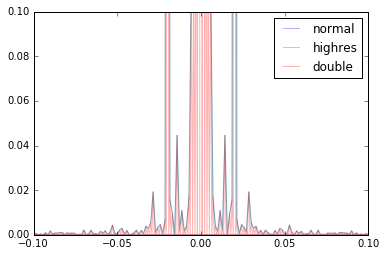

PSD of double length signal:
[ 5.83165819  0.          2.9680445   0.          0.20848357  0.
  0.11605487  0.          0.12043973  0.        ]


In [238]:
fs = [np.fft.fft(s) for s in signals]
psds = [np.abs(x/n)**2 for x,n in zip(fs,ns)]

freqs = [np.fft.fftfreq(n, d=d) for n,d in zip(ns, ds)]
for freq, psd, l in zip(freqs, psds, labels):
    plt.plot(freq, psd, alpha=0.3, label = l)
plt.ylim(0, 0.1)
plt.xlim(-0.1, 0.1)
plt.legend(loc="best")
plt.show()
print("PSD of double length signal:")
print(psds[2][:10])

As you can see the PSDs of the signals are very similar. For the signal with double length, every second component is zero. The mathematical reason is of course that the terms in the internal sum in the FFT cancel out each other. As an interpretation I would think that we get finer frequency bins with increased length, but these finer frequencies don't "align" with the signal, because they would have to align with each repetition - which is only the case for each k-th frequency bin if we have k repetitions. If a mathematician ever reads this, I would be happy to hear a more precise interpretation of this phenomenon.

For our purpose, it is probably most important that the zeros make sense, because if they would not be there our sum of powers would be twice as high as for the normal signal.

Anyway, we can now check if our PSDs make sense by comparing the sum of the components to the variance of the original signals:

In [239]:
def fi(d, f, n):
    # f = i  * d / n
    # => i = f / d * n
    return round(f / d * n)

powers = [np.sum(psd[1:]) for psd,fstep in zip(psds, fsteps)]
for p,s,l in zip(powers, signals, labels):
    print("total power ({:7s}): {:.3f}".format(l, p))
    print("variance    ({:7s}): {:.3f}".format(l, np.var(s)))

total power (normal ): 9.861
variance    (normal ): 9.861
total power (highres): 9.861
variance    (highres): 9.861
total power (double ): 9.861
variance    (double ): 9.861


It seems that everything works out fine. Wat remains is to build a small function that can easily extract a frequency band and compute its power.

In [240]:
def fi(d, f, n):
    # f(requency) = i(ndex)  / (d * n)
    # => i = f * d * n
    return round(f * d * n)

ds_test = [0.1, 0.4, 0.3, 0.1]
fs_test = [1, 0.75, 1.1, 0.5]
ns_test = [100, 10, 50, 70]
for f,d,n in zip(fs_test, ds_test, ns_test):
    print("{:.3f} = {:.3f}".format(f, np.fft.fftfreq(n, d=d)[fi(d,f,n)]))

def band_power(signal, low, high, d=1):
    n = len(signal)
    # compute PSD
    psd = (np.abs(np.fft.fft(signal)) / n) ** 2
    # compute indices where to find frequencies in PSD
    li = fi(d, low, n)
    hi = fi(d, high, n)
    # take sum of PSD over these indices
    # and multiply by two to also account for negative frequencies
    return np.sum(psd[li:hi]) * 2

bands = [(0.001, sin_freq - 0.001), (sin_freq - 0.001, sin_freq + 0.01)]
for low, high in bands:
    bps = [band_power(s, low, high, d=d) for s,d in zip(signals, ds)]
    for bp,l in zip(bps, labels):
        print("Band power {:7s} ({:.3f} hz - {:.3f} hz) = {:.3f}".format(l, low, high, bp))

1.000 = 1.000
0.750 = 0.750
1.100 = 1.067
0.500 = 0.571
Band power normal  (0.001 hz - 0.019 hz) = 7.008
Band power highres (0.001 hz - 0.019 hz) = 7.008
Band power double  (0.001 hz - 0.019 hz) = 7.039
Band power normal  (0.019 hz - 0.030 hz) = 2.680
Band power highres (0.019 hz - 0.030 hz) = 2.679
Band power double  (0.019 hz - 0.030 hz) = 2.649


As you can see, our PSD estimate also works out for frequency bands. One interesting feature of the PSD is, that we can now tell how much a certain frequency band contributes to the overall variance of a signal.

In [242]:
sin_contrib = band_power(signals[0], sin_freq - 0.001, sin_freq + 0.001, d=ds[0])/powers[0]
print("contribution of sine wave to whole signal variance: {:.0f}%".format(sin_contrib * 100))

contribution of sine wave to whole signal variance: 26%
